In [11]:
#get essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#get preprocessing and metric libraries
import sklearn.metrics as sk_metrics
import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

#get the model and visualisation method
import sys
sys.path.append('../')
import nam.wrapper as nam_models
import seaborn as sns


In [3]:
#get the data
heart_data = pd.read_csv('../../../Data/Heart/heart_2020_cleaned.csv')

In [4]:
#Undersample the data because of class imbalance
print("size of data before sampling", heart_data.shape)
sick = heart_data[heart_data['HeartDisease'] == 'Yes']
healthy = heart_data[heart_data['HeartDisease'] == 'No']
healthy = healthy.sample(n = len(sick) * 2, random_state = 1024)
print("ratio of sick people ", len(sick) / (len(healthy) + len(sick)))

combine = [sick, healthy]
heart_data = pd.concat(combine, axis = 0)
print("size of data after sampling ", heart_data.shape)

#split the data and encode target catecorigal variables
target_heart = heart_data['HeartDisease']
encoder = preproc.LabelEncoder()
target_heart = encoder.fit_transform(target_heart)
train_heart = heart_data.drop(['HeartDisease', 'GenHealth'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(train_heart, target_heart, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(train_heart, target_heart, test_size=(0.15 / (0.15 + 0.7) ))


size of data before sampling (319795, 18)
ratio of sick people  0.3333333333333333
size of data after sampling  (82119, 18)


In [5]:
#create a list of column names into three categories: numerical data, 
#catecorigal data with two unique vals, and catecorigal data with more than 2 values

#this is for the column transofrmer. We will use different preprocessing methods depending on
#the features data type

numerical_cols = []
categorical_cols = []

for c in X_train.columns:
    if X_train[c].dtype == X_train['BMI'].dtype:
        numerical_cols.append(c)
    else:
        categorical_cols.append(c)

    

In [6]:
col_names = numerical_cols + categorical_cols

In [7]:
#create the columntransformer object and set the preprocessing methods for each column
ct = ColumnTransformer([
    ("MinMax scaling numerical variables", preproc.MinMaxScaler((-1, 1)), numerical_cols),
    ("Encoding catecorigal variables", preproc.OrdinalEncoder(), categorical_cols)
])
ct.fit(X_train)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
#Create and fit the model
nam_classifier = nam_models.NAMClassifier(
                        lr=0.0157,
                        metric='AUC',
                        num_learners=10
)
nam_classifier.fit(X_train, y_train)


In [16]:
#evaluate the model
prediction_prob = nam_classifier.predict_proba(X_test)

precision, recall, _ = sk_metrics.precision_recall_curve(y_test, prediction_prob)



In [17]:
print("AUC score is ", sk_metrics.auc(recall, precision))


AUC score is  0.6870474283937308


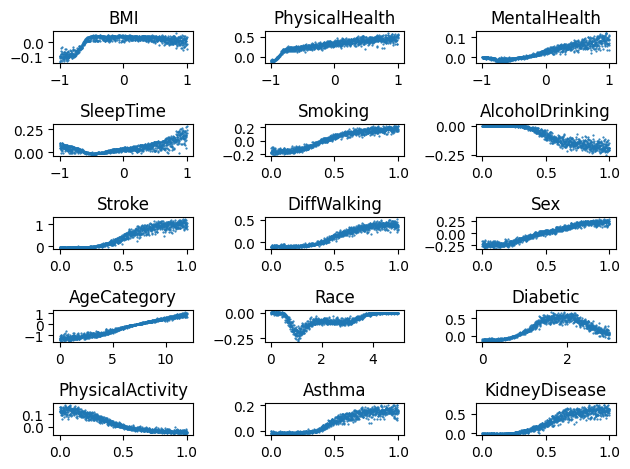

In [14]:
#time to visualise

figure, axis = plt.subplots(5, 3)
counter = 0
for i in range(5):
    for j in range(3):
        column_of_data = X_train[:, counter]
        vis_data = nam_classifier.plot(counter, column_of_data)
        axis[i, j].scatter(vis_data['x'], vis_data['y'], s=0.3)
        axis[i, j].set_title(col_names[counter])
        counter += 1
plt.tight_layout()

In [15]:
age_data = nam_classifier.plot(9, X_train[:, 9])
sex_data = nam_classifier.plot(6, X_train[:, 8])
diabetic_data = nam_classifier.plot(11, X_train[:, 11])
%store age_data
%store sex_data
%store diabetic_data

Stored 'age_data' (dict)
Stored 'sex_data' (dict)
Stored 'diabetic_data' (dict)
